In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import math

# Functions

In [6]:
def one_hot_encoder(v):
    return np.eye(v.max()+1)[v]
def one_hot_decoder(v):
    return np.argmax(v,axis=1)
def softmax(v):
    expv=np.exp(v)
    if v.shape[0]>1:
        return expv/expv.sum(axis=1,keepdims=True)
    else:
        return expv/expv.sum(axis=1)
def class_cost(Y,P):
    return -(Y*np.log(P)).mean()
def accuracy(Y,P):
    return (Y==P).mean()
def rmse(Y,P):
    return np.sqrt(((P-Y)**2).mean())
def populate_W(X,T,net_structure):
    net_structure=[X[0].size]+net_structure+[T[0].size]
    W=[]
    for i in range(len(net_structure)-1):
        W.append(np.random.randn(net_structure[i]+1,net_structure[i+1]))
    return W
def process(X,W):
    X=np.append(X,np.ones((X.shape[0],1)),1)
    return X.dot(W)
def sigmoid(v):
    return 1/(1+np.exp(-v))
def forward(X,W,f_transfer=sigmoid,f_output=sigmoid):
    v=[X]
    for l in range(len(W)-1):
        v.append(f_transfer(process(v[-1],W[l])))
    v.append(f_output(process(v[-1],W[-1])))
    return v
def derivate(layer,delta,W):
    next_delta=delta.dot(W[:-1,:].T)*layer*(1-layer)
    layer=np.append(layer,np.ones((layer.shape[0],1)),1)
    return layer.T.dot(delta),next_delta
def train(X,Y,net_structure,W_0=None,
          f_encode_Y=one_hot_encoder,
          f_decode_Y=one_hot_decoder,
          f_transfer=sigmoid,
          f_output=lambda v: softmax(sigmoid(v)),
          f_cost=class_cost,
          f_accuracy=accuracy,
          frac_test=0.2,random_state=None,
          learning_rate=10e-7,num_rounds=100000,
          report_step=100,print_every=5000,print_acc=True,plot_cost=True):
    reports=[]
    X,Y=sklearn.utils.shuffle(X,Y,random_state=random_state)
    num_test=int(frac_test*X.shape[0])
    X_train,Y_train=X[:-num_test],Y[:-num_test]
    X_test,Y_test=X[-num_test:],Y[-num_test:]
    T_train,T_test=f_encode_Y(Y_train),f_encode_Y(Y_test)
    if W_0!=None:
        W=W_0
    else:
        W=populate_W(X_train,T_train,net_structure)
    for n in range(num_rounds):
        preds_train,preds_test=forward(X_train,W,f_transfer,f_output),forward(X_test,W,f_transfer,f_output)
        if n % report_step==0:
            cost_train,cost_test=f_cost(T_train,preds_train[-1]),f_cost(T_test,preds_test[-1])
            if print_every and n % print_every==0:
                print("{:5d} {:0.5f} {:0.5f}".format(n,cost_train,cost_test))
            reports.append([n,cost_train,cost_test])
        delta=preds_train[-1]-T_train
        for l in reversed(range(len(W))):
            gradient,new_delta=derivate(preds_train[l],delta,W[l])
            delta=new_delta
            W[l]=W[l]-learning_rate*gradient
    cost_train,cost_test=f_cost(T_train,preds_train[-1]),f_cost(T_test,preds_test[-1])
    reports.append((num_rounds,cost_train,cost_test))
    Y_pred_train,Y_pred_test=f_decode_Y(preds_train[-1]),f_decode_Y(preds_test[-1])
    acc_train,acc_test=f_accuracy(Y_train,Y_pred_train),f_accuracy(Y_test,Y_pred_test)
    if print_acc:
        print('Train: {:0.2}, Test: {:0.2}'.format(acc_train,acc_test))
    if plot_cost:
        plt.plot([r[1] for r in reports])
        plt.plot([r[2] for r in reports])
        plt.show()
    return W,reports,(acc_train,acc_test)

# 2D, multiclass data

In [3]:
num_classes=3
num_per_class=500
r=3*num_classes/math.pi
d=2*math.pi/num_classes
centers=[[r*math.cos(n*d),r*math.sin(n*d)] for n in range(num_classes)]
X_lst=[]
for c in range(num_classes):
    X_lst.append(np.random.randn(num_per_class,2) + np.array(centers[c]))
X_class=np.concatenate(X_lst,axis=0)
Y_class=np.array([ co for l in [[cl]*num_per_class for cl in range(num_classes)] for co in l ])

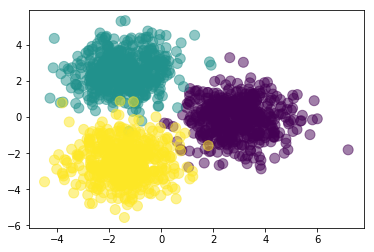

In [4]:
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

## Modeling

    0 0.34260 0.33962
 1000 0.26506 0.26346
 2000 0.23585 0.23512
 3000 0.22146 0.22139
 4000 0.21354 0.21388
 5000 0.20863 0.20929
 6000 0.20532 0.20623
 7000 0.20297 0.20405
 8000 0.20124 0.20240
 9000 0.19993 0.20109
Train: 0.98, Test: 0.97


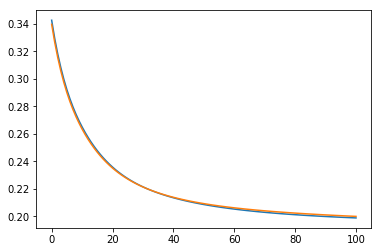

CPU times: user 7.04 s, sys: 156 ms, total: 7.2 s
Wall time: 7.03 s


In [7]:
%%time
W,report,accs=train(X_class,Y_class,net_structure=[3],
                    f_encode_Y=one_hot_encoder,
                    f_decode_Y=one_hot_decoder,
                    f_transfer=sigmoid,
                    f_output=lambda v: softmax(sigmoid(v)),
                    f_cost=class_cost,
                    f_accuracy=accuracy,
                    learning_rate=10e-6,num_rounds=10000,print_every=1000)

# 2D, single class data

In [8]:
num_classes=2
num_per_class=500
r=3*num_classes/math.pi
d=2*math.pi/num_classes
centers=[[r*math.cos(n*d),r*math.sin(n*d)] for n in range(num_classes)]
X_lst=[]
for c in range(num_classes):
    X_lst.append(np.random.randn(num_per_class,2) + np.array(centers[c]))
X_class=np.concatenate(X_lst,axis=0)
Y_class=np.array([ co for l in [[cl]*num_per_class for cl in range(num_classes)] for co in l ])

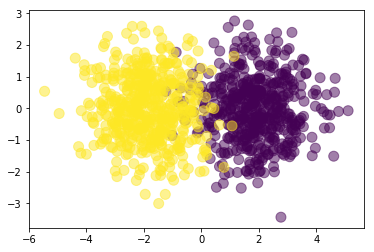

In [9]:
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

## Modeling

    0 0.36430 0.31504
 1000 0.17761 0.14443
 2000 0.12575 0.09424
 3000 0.09864 0.06836
 4000 0.08256 0.05320
 5000 0.07229 0.04356
 6000 0.06539 0.03702
 7000 0.06054 0.03237
 8000 0.05703 0.02892
 9000 0.05441 0.02628
Train: 0.97, Test: 0.96


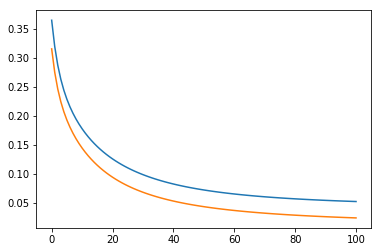

CPU times: user 3.21 s, sys: 168 ms, total: 3.38 s
Wall time: 3.19 s


In [11]:
%%time
W,report,accs=train(X_class,Y_class,net_structure=[3],
                    f_encode_Y=lambda v: v.reshape((-1,1)),
                    f_decode_Y=lambda v: v.ravel().round().astype(int),
                    f_transfer=sigmoid,
                    f_output=sigmoid,
                    f_cost=class_cost,
                    f_accuracy=accuracy,
                    learning_rate=10e-6,num_rounds=10000,print_every=1000)

# 2D, regression data

In [26]:
num_points=1000
noise_level=0.2
X_reg=np.random.uniform(0,1,(num_points,2))
plane=np.random.randn(3)
Y_reg=np.append(X_reg,np.ones((X_reg.shape[0],1)),1).dot(plane)+noise_level*np.random.randn(num_points)

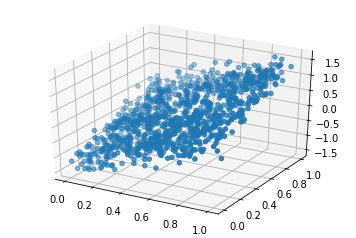

In [27]:
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(X_reg[:,0],X_reg[:,1],Y_reg)

## Modeling

    0 1.72724 1.69479
 1000 0.49426 0.52093
 2000 0.46034 0.48657
 3000 0.42003 0.44569
 4000 0.37515 0.40015
 5000 0.32967 0.35393
 6000 0.28836 0.31182
 7000 0.25491 0.27743
 8000 0.23065 0.25211
 9000 0.21472 0.23502
Train: 0.21, Test: 0.22


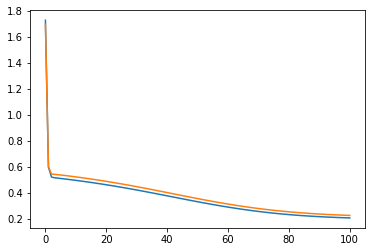

CPU times: user 2.72 s, sys: 156 ms, total: 2.87 s
Wall time: 2.69 s


In [28]:
%%time
W,report,accs=train(X_reg,Y_reg,net_structure=[3],
                    f_encode_Y=lambda v: v.reshape((-1,1)),
                    f_decode_Y=lambda v: v.ravel(),
                    f_transfer=sigmoid,
                    f_output=lambda v: v,
                    f_cost=rmse,
                    f_accuracy=rmse,
                    learning_rate=10e-6,num_rounds=10000,print_every=1000)

In [29]:
P=forward(X_reg,W,f_output=lambda v: v)

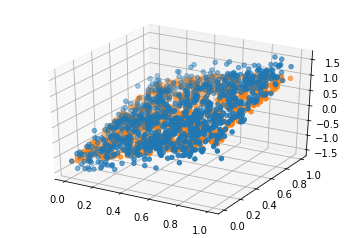

In [30]:
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(X_reg[:,0],X_reg[:,1],Y_reg)
ax.scatter(X_reg[:,0],X_reg[:,1],P[-1])